# Assignment 2: Write code that enhances images

In [148]:
#!pip3 install opencv-python
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import requests
from io import BytesIO

## PreReq: load the images

In [149]:
""" Uploaded the images to my github repo so that this colab can be run from anywhere """
def read_image_from_github(suffix):
    url ='https://github.com/ignitewala/dipa02/raw/refs/heads/main/'
    response = requests.get(url+suffix)
    if response.status_code == 200:
        img_array = np.asarray(bytearray(response.content), dtype=np.uint8)
        img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        return img
    else:
        raise ValueError(f"Failed to fetch image from URL: {url}")

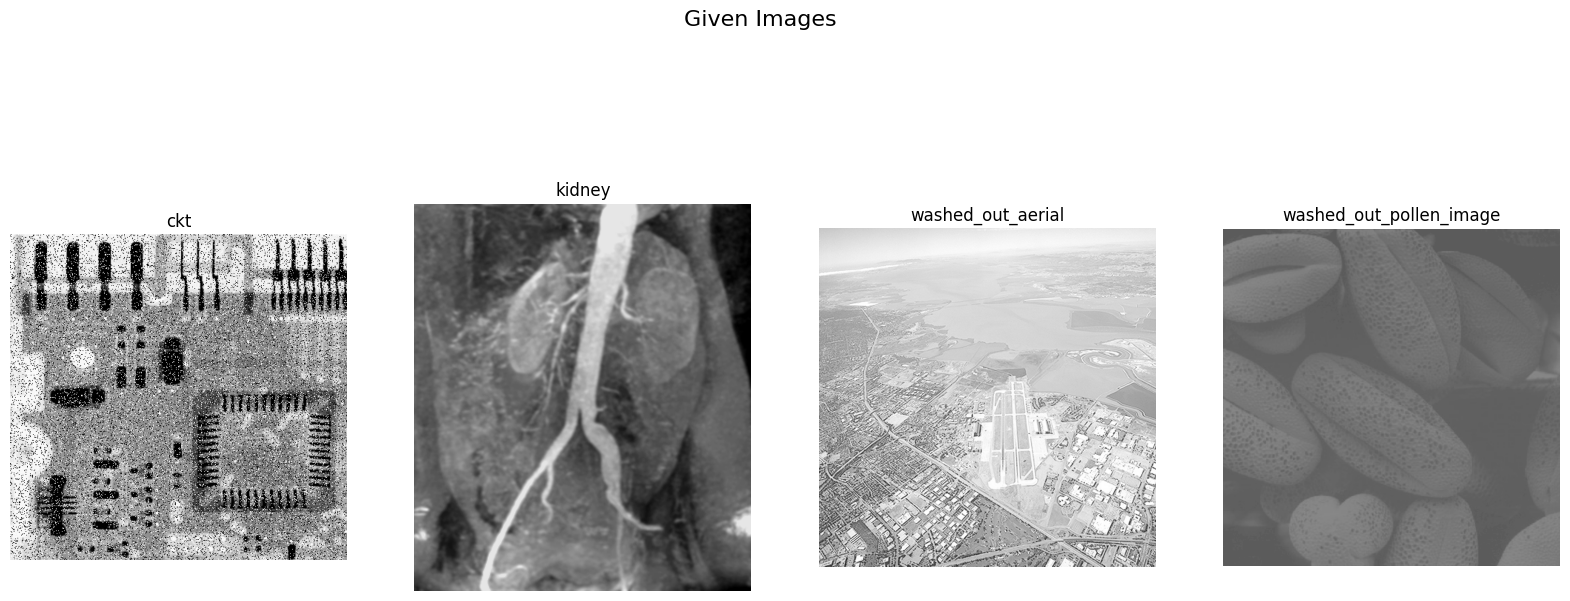

In [150]:
images =[]
files=['ckt.pgm', 'kidney.pgm', 'washed_out_aerial.pgm', 'washed_out_pollen_image.pgm']
image_map ={}
for path in files:
  image_map[path.removeprefix('/content/').replace('.pgm','')] = read_image_from_github(path)

plt.figure(figsize=(20, 8))
for i, file in enumerate([*image_map]):
    plt.subplot(1, 4, i+1)
    plt.imshow(image_map[file])
    plt.title("%s" % file)
    plt.axis('off')
plt.suptitle("Given Images", fontsize=16)
plt.show()


## Q1: Enhances a given image by

### A: Gamma correction

In [151]:
## algorithm from Prof's notes and in book -
## more the value of gamma, it darkens the image
def gamma_correction(gamma, gray):
    corrected = np.power(gray / 255.0, gamma)
    corrected = (corrected * 255).astype(np.uint8)

    return corrected



> Choosing the 'washed_out_aerial.pgm' image as it has more 'whitish' pixels. A larger gamma value will adjust the brightness and make it darker



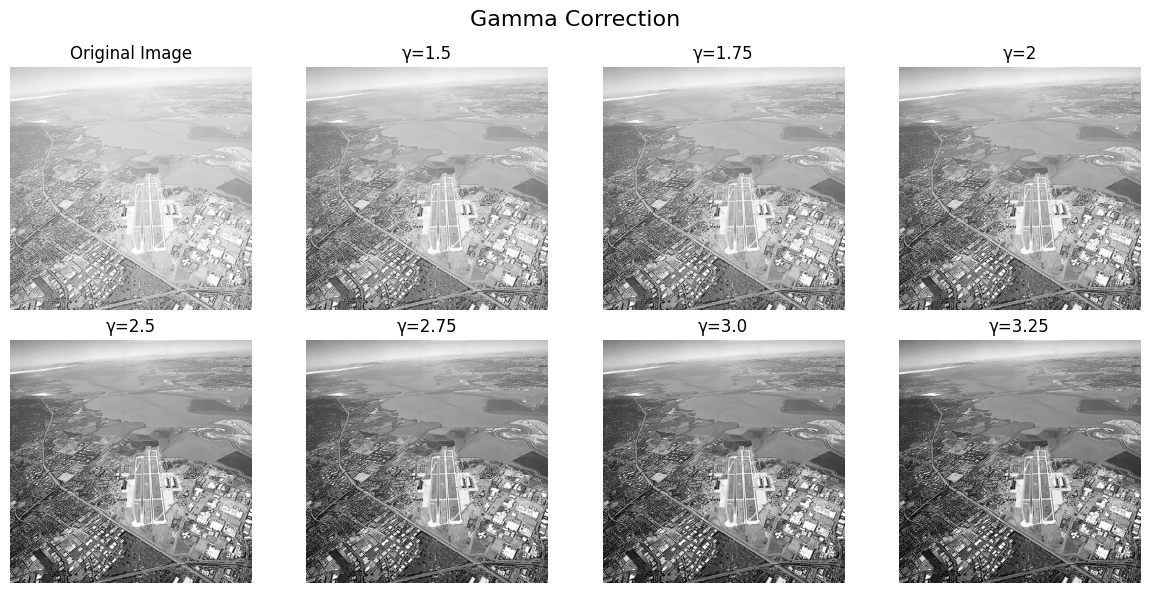

In [152]:
original = image_map['washed_out_aerial']
gammas = [1.5, 1.75, 2, 2.5, 2.75, 3.0, 3.25]


## Configuing 2 rows plot
total_images = len(gammas) + 1
rows = (total_images + 3) // 4
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
plt.suptitle("Gamma Correction", fontsize=16)
axes = axes.flatten()

# the first image is the original one
axes[0].imshow(original)
axes[0].set_title("Original Image")
axes[0].axis("off")


# For each gamma value, correcting the original image and showing
for idx, gamma in enumerate(gammas):
    # correct the gamma of the original image
    img_corrected = gamma_correction(gamma, original)
    axes[idx + 1].imshow(img_corrected)
    axes[idx + 1].set_title(f"γ={gamma}")
    axes[idx + 1].axis("off")


plt.tight_layout()
plt.show()

### B: Histogram Equalisation

In [153]:
"""
The following method counts frequncy of image intensity values
"""
def calculate_intensity_freq(gray):
    all_pixles =gray.flatten()

    histogram = np.zeros(256, dtype=int)

    for pixel_value in all_pixles:
        histogram[pixel_value] += 1

    return histogram

"""
 Creates new image with equalized intensity values. keeps the original images' shape intact
"""
def equalized_image(original_image, lookUpTable):

    mapped_img = original_image.copy()
    height, width, channels = mapped_img.shape

    for y in range(height):
        for x in range(width):
            for channel in range(channels):
                mapped_img[y, x, channel] = lookUpTable[original_image[y, x, channel]]
    return mapped_img

############################################
# HELPER METHODS for plotting images
#############################################

def plot_pixels(histogram, img):
    x=list(range(256))
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Frequency of intesity')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.plot(x,histogram)

    plt.subplot(1, 3, 3)
    plt.title('Histogram of intesity')
    plt.hist(histogram, color='skyblue', edgecolor='black')
    plt.xlabel('Bin')
    plt.ylabel('Intensity')

    plt.show()


def plot_side_by_side(original_image, enhanced_image, original_freq, enhanced_feq):
    x=list(range(256))
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 4, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')


    plt.subplot(1, 4, 2)
    plt.imshow(enhanced_image)
    plt.title('Enhacned Image')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title('Intensity Count(Original) ')
    plt.xlabel('Intensity')
    plt.ylabel('No of Pixels')
    plt.plot(x,original_freq)

    plt.subplot(1, 4, 4)
    plt.title('Intensity Count(Enhacned)')
    plt.xlabel('Intensity')
    plt.ylabel('No of Pixels')
    plt.plot(x,enhanced_feq)

    plt.show()



> The 'washed_out_pollen_image' image looks darker, the intensity of pixels are concentrated in the 100-150 range, need to be equalised for better disribution of pixels acorss the 0-255 range



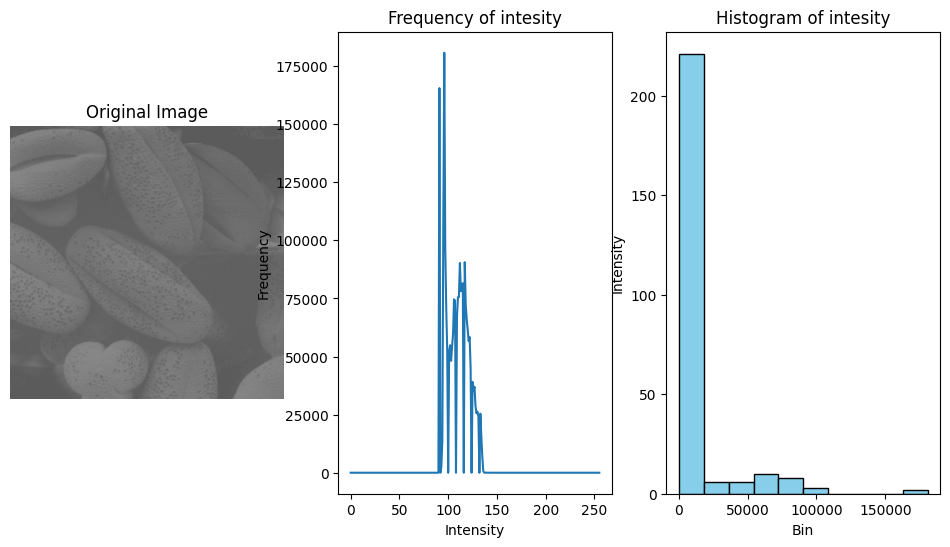

In [154]:
original =image_map['washed_out_pollen_image']
intensity_freq =calculate_intensity_freq(original)
plot_pixels(intensity_freq, original)

Creating my **custom logic for Histogram Equalisation**

In [155]:
class HistEqualisationRow :
    """
     This class holds the R_k, N_k, and previous row's CDF to accumulate CDF values
    """
    def __init__(self, rk, nk, total_count, cdf_prev=0, factor=255):
        self.rk = rk
        self.nk = nk
        self.total_count=total_count
        self.cdf=cdf_prev
        self.factor = factor
        self.pdf =0
        self.skBits =0
        self.level =0


    """
     This method calculate PDF of Rk i.e. P(R_k) = N_k/Total , adds current pdf with last step's  CDF. then multiplies
     the current CDF with the fatcor. Factor is 255 for 8 bit images
     Finally rounds off the value to get the newest value mapping R_k to new round of (CDF*factor)
    """
    def build(self):
        self.pdf = self.nk/self.total_count
        self.cdf += self.pdf
        self.skBits = self.factor * self.cdf
        self.level = round(self.skBits)
        return self.level, self.cdf

    def row(self):
        row_data = [self.rk , self.nk , self.pdf , self.cdf, self.skBits, self.level]
        return row_data

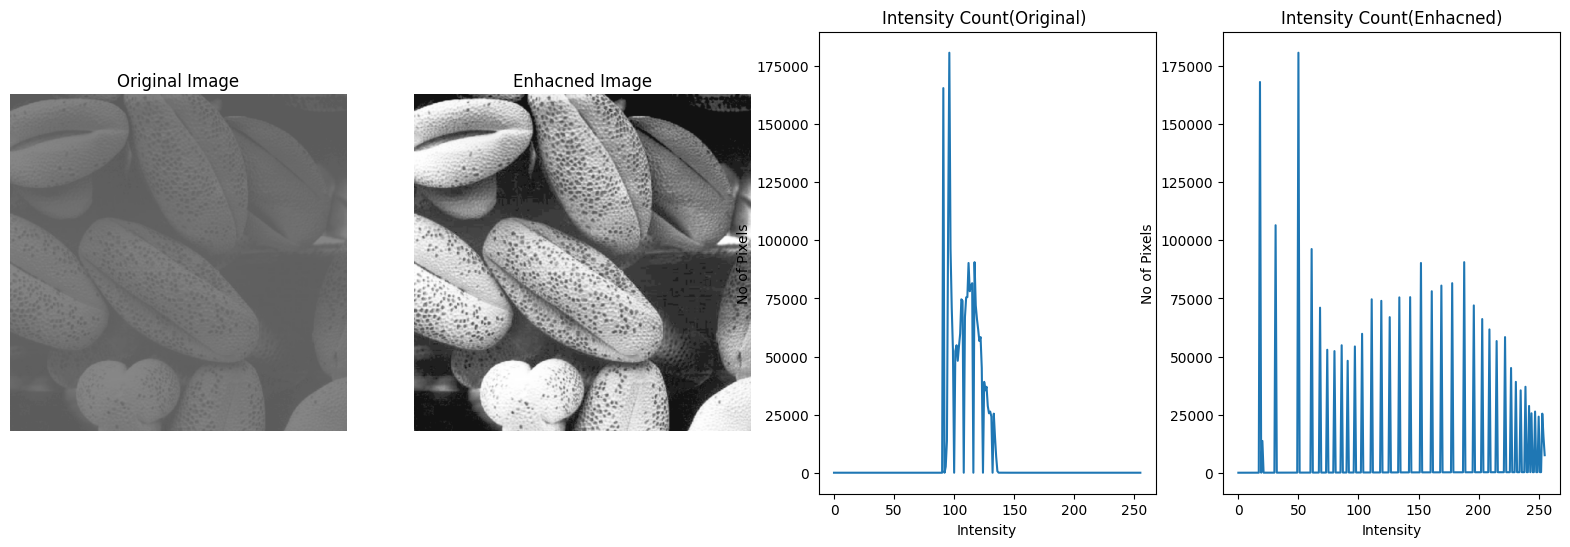

In [156]:
from collections import defaultdict

# this table holds HistEqualisationRow, such as the key =0, holds the PDF, CDF, new level for the 0th intensity
# it has 256 keys and corresponding table rows
table = {}

# total pixles required for probability calculation
total_count = intensity_freq.sum()

# look_up_table[x] holds the new level after applying the algorithm for intensity=x (x ranges from 0..255)
look_up_table = defaultdict(int)

# the reverse_table maps new label to old intensity lable
reverse_table= defaultdict(int)

cdf_old =0

#loop through the intensity frequencies and build the table of CDF, new level for each original intensity
# the intensity new_level and old level are mapped in the look_up_table
# look_up_table[125] holds the new level after applying the algorithm
for idx, data in enumerate(intensity_freq):
    row = HistEqualisationRow(idx, data, total_count,  cdf_old)
    new_level, cdf_old = row.build()
    table[idx] = row
    look_up_table[idx] = new_level


# sum the N_ks for new intensity levels
for r in  table:
    ht= table[r]
    reverse_table[ht.level] += ht.nk


# it will hold the new frequencies for each intensity after equalisation
new_histogram =list(range(256))
## Populate the intensity frequncy for each intensity (0..255)
for i in reverse_table:
    new_histogram[i] =reverse_table[i]


enhanced_image =equalized_image(original, look_up_table)


plot_side_by_side(original, enhanced_image, intensity_freq, new_histogram)

## Q2: Convert a given image of 8-bits to 6,4,2 and 1 bit resolution

In [157]:
def reduce_bit_depth(original_img, target_bits):
    reduced_img = original_img.copy()
    alpha=2 ** (8 - target_bits)
    reduced_img = np.floor(original_img / alpha) * alpha

    return reduced_img.astype(np.uint8)

def show_images(images, bits):

    plt.figure(figsize=(20, 8))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(img)
        plt.title(" %d Bits" % bits[i])
        plt.axis('off')

    plt.show()



> Processing the kidney image to represent in lower bits



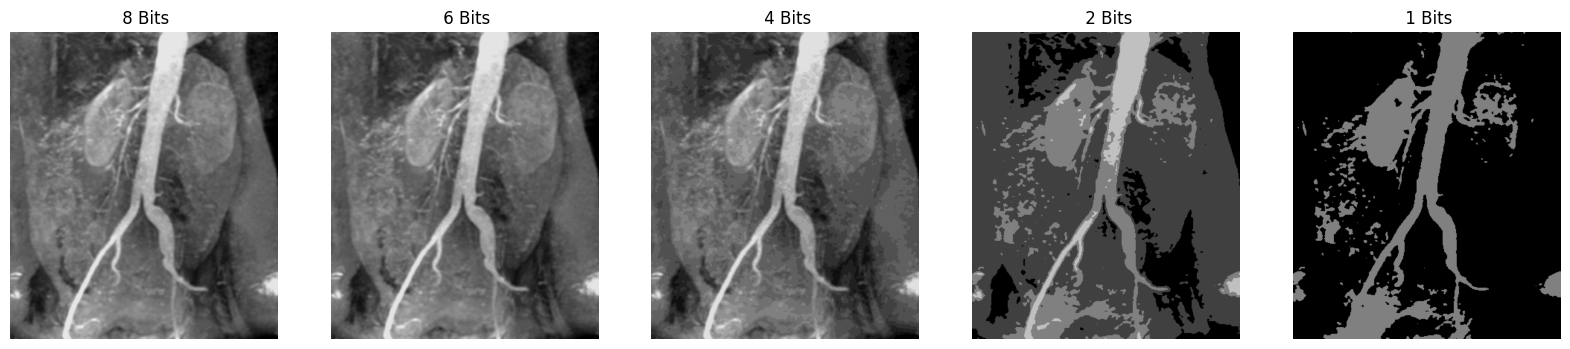

In [158]:
img = image_map['kidney']
bits =[8, 6, 4, 2, 1]
images =[]
for i, bit in enumerate(bits):
    images.append(reduce_bit_depth(img, bit))

show_images(images, bits)


# Q3. Reduce the spatial resolution of a given image by W/2 * H/2



> Down smapling is the best way to reduce the iamge size. I will try the following
*   my custom down-smapling logic
*   CV2 API

Sir mentioned in the class interpolation helps in image resolution increasing and not a good option for down-sizing, still I will give it a shot


In [159]:
def resampling_custom(image, new_width, new_height):
    """
        Uses re-sampling for resizing with custom implementation
    """
    orig_height, orig_width, channels = image.shape
    resized = np.zeros((new_height, new_width, channels), dtype=image.dtype)
    x_ratio = orig_width / new_width
    y_ratio = orig_height / new_height
    for i in range(new_height):
        for j in range(new_width):
            for channel in range(channels):
                orig_x = int(j * x_ratio)
                orig_y = int(i * y_ratio)

                # bounded pixel
                if orig_x >= orig_width:
                    orig_x = orig_width - 1
                if orig_y >= orig_height:
                    orig_y = orig_height - 1

                resized[i, j, channel] = image[orig_y, orig_x, channel]

    return resized

def resample_cv2(image, new_width, new_height):
    resized = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized

def bilinear_interpolation(image):
    """
    Uses bi-linear interpolation to resize
    """
    old_height, old_width, channels = image.shape
    new_height, new_width = old_height//2, old_width//2
    resized_image = np.zeros((new_height, new_width, channels), dtype=np.uint8)

    # Scale factors
    row_scale = old_height / new_height
    col_scale = old_width / new_width

    for i in range(new_height):
        for j in range(new_width):
            for channel in range(channels):
                # Map the pixel in the output image to the input image
                x = i * row_scale
                y = j * col_scale

                # Find the coordinates of the surrounding pixels
                x1 = int(np.floor(x))
                x2 = min(x1 + 1, old_height - 1)
                y1 = int(np.floor(y))
                y2 = min(y1 + 1, old_width - 1)

                # Compute the weights for interpolation
                a = x - x1
                b = y - y1

                # Perform bilinear interpolation
                resized_image[i, j, channel] = (
                   int((1 - a) * (1 - b) * image[x1, y1, channel] +
                    a * (1 - b) * image[x2, y1, channel] +
                    (1 - a) * b * image[x1, y2, channel] +
                    a * b * image[x2, y2, channel])
                )

    return resized_image



> Original 'Kidney' size is (828 X 720), it will be downsized to (414 X 360)



(828, 720, 3)


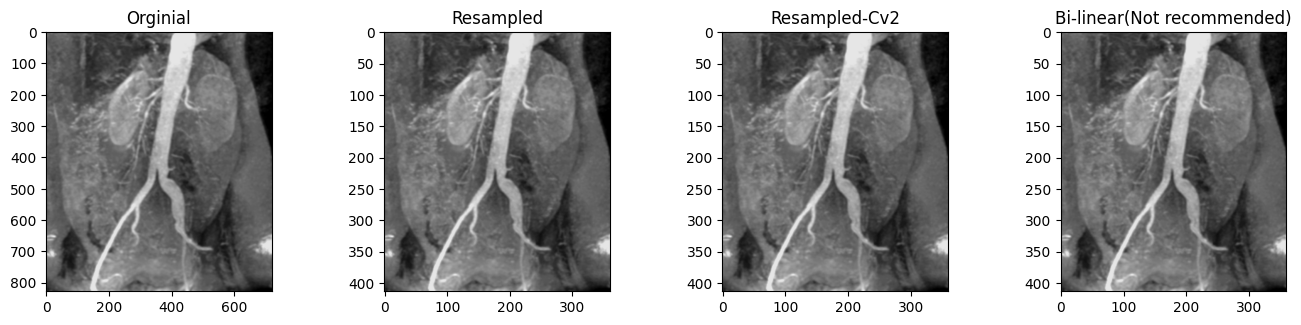

In [160]:
original_image = image_map['kidney']
resized_image = bilinear_interpolation(original_image)
shape = original_image.shape;
print(shape)
resampled_image = resampling_custom(original_image, shape[1]//2, shape[0]//2)
resampled_image_cv2 = resample_cv2(original_image, shape[1]//2, shape[0]//2)

images = [original_image, resampled_image, resampled_image_cv2, resized_image]
titles =["Orginial","Resampled", "Resampled-Cv2", "Bi-linear(Not recommended)"]

plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace=0.5, hspace=0.3)
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    plt.title(titles[i])
    plt.imshow(images[i], cmap='gray')

plt.show()

# Q4: Lowpass filter a given image by 3X3 5X5 and 7X7



The **'ckt'** circuit image has **salt & pepper** noise, low-pass spatial filtering would smoothen the image and remove grains/noises
Observation:
1.   3X3 removes background **salt & pepper** noises
2.   5X5 optimum smoothening
3.   7X7 almost blurs





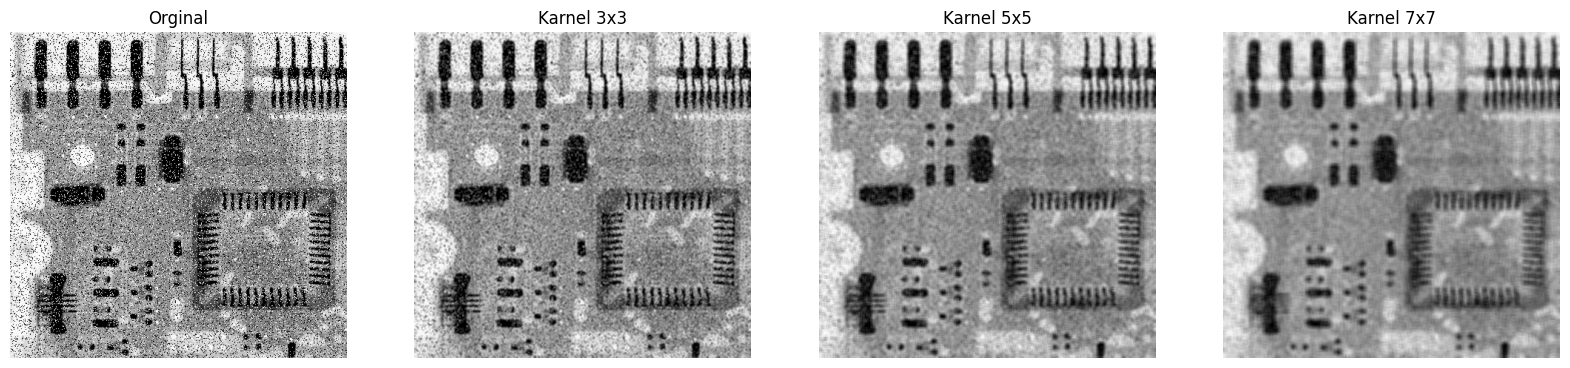

In [161]:
def lowpass_filter(image, kernel_size):
    kernel = np.ones((kernel_size, kernel_size), np.int8) / (kernel_size**2)
    filtered_image = cv2.filter2D(image, -1, kernel)
    return filtered_image

original_image = image_map['ckt']
images =[original_image]
titles =['Orginal']

# Apply low-pass filters with different kernel sizes
for kernel_size in [3, 5, 7]:
    filtered_image = lowpass_filter(original_image, kernel_size)
    images.append(filtered_image)
    titles.append(f"Karnel {kernel_size}x{kernel_size}")

# Loop through the filtered images and show
plt.figure(figsize=(20, 8))
for i, img in enumerate(images):
    plt.subplot(1, len(images), i+1)
    plt.imshow(img)
    plt.title(titles[i])
    plt.axis('off')

plt.show()

# Q5: Lowpass filter a given image in frequency domain

> The 'ckt' circuit image has salt & pepper noise, low-pass  filtering would smooethen the image and remove grains/noises

In [162]:
def frequency_domain_lowpass_filter(image, D0=30):
    """
    Performs steps 1 to 8. starts with padding 2M and 2N
    """
    # Get original image dimensions.
    M, N = image.shape

    # 1. Determine padded dimensions.
    P = 2 * M
    Q = 2 * N

    # 2. Form a padded image of size (P, Q) by zero-padding.
    padded = np.zeros((P, Q), dtype=image.dtype)
    padded[:M, :N] = image

    # 3. Multiply by (-1)^(x+y) to center the transform.
    # Create coordinate grids for the padded image.
    X, Y = np.meshgrid(np.arange(Q), np.arange(P))
    centered = padded * ((-1) ** (X + Y))

    # 4. Compute the DFT of the centered image.
    F = np.fft.fft2(centered)

    # 5. Generate a real, symmetric filter function H(u, v) of size (P, Q)
    #    with its center at (P/2, Q/2).
    H = ideal_low_pass_filter(P, Q, D0)

    # 6. Multiply F(u,v) by H(u,v) (element-wise multiplication).
    G = F * H

    # 7. Perform IDFT of the product.
    g = np.fft.ifft2(G)
    # Take only the real part (to ignore small imaginary components).
    g = np.real(g)

    # Multiply by (-1)^(x+y) to re-center the image.
    g = g * ((-1) ** (X + Y))

    # 8. Extract the final processed image by cropping back to original size.
    processed_image = g[:M, :N]

    return processed_image

def ideal_low_pass_filter(P, Q, D0):
    """
    Create an ideal low-pass filter of size (P, Q) with cutoff frequency D0.

    Parameters:
      P, Q (int): Dimensions of the filter.
      D0 (float): Cutoff frequency. I will pass 30, 50, 70, 100 for testing
    """

    U, V = np.meshgrid(np.arange(Q), np.arange(P))
    D = np.sqrt((U - Q/2) ** 2 + (V - P/2) ** 2)
    H = np.zeros((P, Q))
    H[D <= D0] = 1
    return H


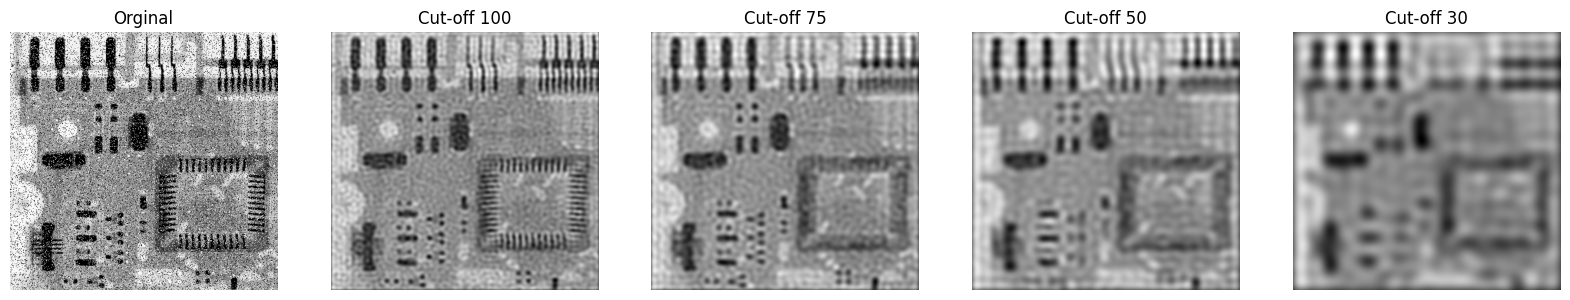

In [163]:
# converting 3 channel to 1 channel image for my custom calcualtion in 2D array
original_image = cv2.cvtColor(image_map['ckt'], cv2.COLOR_BGR2GRAY)

images =[original_image]
titles =['Orginal']

# Apply low-pass filters with different frequencies
# when I pass 30, the filter will block all frequencies above 30 and pass anything within 30
# similary for 100, 75,50
for frequency in [100, 75, 50, 30]:
    filtered_image = frequency_domain_lowpass_filter(original_image, frequency)
    images.append(filtered_image)
    titles.append(f"Cut-off {frequency}")

plt.figure(figsize=(20, 8))
for i, img in enumerate(images):
    plt.subplot(1, len(images), i+1)
    plt.imshow(img, cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.show()